# Part II: Data exploration

Date: 25/08/2022

Authors: Jordi Bolibar & Facundo Sapienza

Once we have successfully retrieved the training dataset using OGGM, we can start exploring and understanding the dataset. The goal of this notebook will be to perform some basic data analysis techniques on the data, and to understand the physical reasons behind the selected features for the model. 

> **_NOTE_** Before running this notebook, be sure you Jupyter kernel (top left corner of the notebook) has been configure to work with the MB_Finsen conda environment. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preparation

Since we have records of mass balance every 10 years, we will assign to each hydrological year in every period 2000-2010 and 2010-2020 the same part of mass balance that results from grabing the total mass balance in the 1o year period and divide it by 10. 

In [2]:
df_target = pd.read_csv('Data/mb_df.csv')

# Restrict to the two target peroids we have for training
df_target = df_target.replace({'2000-01-01_2010-01-01': '2000-2010',
                               '2010-01-01_2020-01-01': '2010-2020'})
df_target = df_target[df_target.period.isin(['2000-2010', '2010-2020'])]
# We add an unique id to each row to recognized repeited measurements 
df_target['target_id'] = np.arange(0, df_target.shape[0])

# Add hydro year of the target 
dfs = []
for i in range(10):
    df_ = df_target.copy()
    df_['hydro_year'] = np.select([(df_.period=='2000-2010'),
                                         (df_.period=='2010-2020')], 
                                         [2000+i, 2010+i])
    dfs.append(df_)

df_target = pd.concat(dfs, axis=0)
df_target = df_target.set_index(['rgi_id', 'hydro_year'])
df_target = df_target.sort_values(['rgi_id', 'hydro_year'])
df_target = df_target[['dmdtda', 'err_dmdtda', 'period','target_id']]
df_target

dmdtda  err_dmdtda     period  target_id
rgi_id         hydro_year                                            
RGI60-08.00001 2000       -0.458772     0.44912  2000-2010          0
               2001       -0.458772     0.44912  2000-2010          0
               2002       -0.458772     0.44912  2000-2010          0
               2003       -0.458772     0.44912  2000-2010          0
               2004       -0.458772     0.44912  2000-2010          0
...                             ...         ...        ...        ...
RGI60-08.03417 2015        0.389200     0.49660  2010-2020       6833
               2016        0.389200     0.49660  2010-2020       6833
               2017        0.389200     0.49660  2010-2020       6833
               2018        0.389200     0.49660  2010-2020       6833
               2019        0.389200     0.49660  2010-2020       6833

[68340 rows x 4 columns]

We now read the input data and merge it with the target response.

In [3]:
df_features = pd.read_csv('Data/training_df.csv', index_col=['rgi_id', 'hydro_year'])
df_features

PDD          RGI_ID  area  icecap     lat  \
rgi_id         hydro_year                                                    
RGI60-08.00001 2000        40.322890  RGI60-08.00001  0.03       0  67.930   
               2001        42.489556  RGI60-08.00001  0.03       0  67.930   
               2002        38.044445  RGI60-08.00001  0.03       0  67.930   
               2003        39.844445  RGI60-08.00001  0.03       0  67.930   
               2004        40.577779  RGI60-08.00001  0.03       0  67.930   
...                              ...             ...   ...     ...     ...   
RGI60-08.03417 2015        51.437776  RGI60-08.03417  0.15       0  65.923   
               2016        55.643333  RGI60-08.03417  0.15       0  65.923   
               2017        50.003331  RGI60-08.03417  0.15       0  65.923   
               2018        57.004444  RGI60-08.03417  0.15       0  65.923   
               2019        54.643332  RGI60-08.03417  0.15       0  65.923   

                              prcp_01     prcp_02     prcp_03     prcp_04  \
rgi_id         hydro_year                                                   
RGI60-08.00001 2000         89.949440   39.799580   51.759113   50.980053   
               2001         50.515020   43.414460   49.670944   27.386324   
               2002         59.345170   29.263450   24.280972   44.494130   
               2003         48.070133   34.243984   27.780344   46.093716   
               2004         78.174040   31.993261   62.266920   28.106590   
...                               ...         ...         ...         ...   
RGI60-08.03417 2015        104.149030  111.409660  266.413970  155.734220   
               2016        217.098800  211.801880  242.586320  101.253310   
               2017         89.045910  149.197240  371.887760  299.347630   
               2018        176.113360  158.276730  192.674560   64.232956   
               2019        217.587550  137.044170  171.008670  167.764050   

                              prcp_05  ...    temp_06   temp_07   temp_08  \
rgi_id         hydro_year              ...                                  
RGI60-08.00001 2000         29.002270  ...  -6.611111 -1.732222  3.233333   
               2001         35.375156  ... -12.011110 -1.865555  1.533333   
               2002         44.540123  ...  -8.044444 -0.898889  3.333334   
               2003         26.073019  ...  -5.611111 -3.232222  4.133333   
               2004         40.665600  ...  -7.111110 -2.298889  3.033333   
...                               ...  ...        ...       ...       ...   
RGI60-08.03417 2015        189.870130  ...  -2.700000 -1.488889  2.322222   
               2016        108.876656  ...  -3.800000 -1.455556  4.088889   
               2017        121.731080  ...  -5.200000 -2.988889  1.355555   
               2018         24.806946  ...  -8.999999 -1.488889  5.588889   
               2019        227.375120  ...  -6.400000  0.211111  2.022222   

                             temp_09    temp_10    temp_11   temp_12    zmax  \
rgi_id         hydro_year                                                      
RGI60-08.00001 2000         9.202221  13.494446  10.450000  5.927779   250.0   
               2001        10.002221  13.594445  10.316667  7.627779   250.0   
               2002         9.202221  13.794446  10.316667  4.727778   250.0   
               2003         6.135554  15.094445  11.316667  6.494445   250.0   
               2004         8.102222  14.727779  11.216666  6.827778   250.0   
...                              ...        ...        ...       ...     ...   
RGI60-08.03417 2015         5.307778   8.482221  10.999999  6.890000  1318.0   
               2016         6.907778  10.382221   8.599999  7.290001  1318.0   
               2017         7.507778   9.482221   8.799999  6.890000  1318.0   
               2018         6.007778  12.582221   9.400000  5.990001  1318.0   
               2019         7.674444  10.182220   9.99

We can aggregate the periods 2000-2010 and 2010-2020 into one single datapoint for training by setting `aggregation=True`. This will makes sense if we are interested in learning just the mass balance in these 10 years periods. However, if we want to have a better resolution and learn the variation of mass balance every one year we may decide to go for the other. This will be harder to train and also more difficult to test without the use of an external dataset. 

In [6]:
aggregation = True

df_all = df_features.merge(df_target, 
                           left_on=['rgi_id','hydro_year'], 
                           right_on=['rgi_id','hydro_year']).drop(['RGI_ID'], axis=1)

if aggregation:
    df_all = df_all.groupby(['rgi_id', 'period']).mean()
df_all

PDD    area  icecap     lat     prcp_01  \
rgi_id         period                                                     
RGI60-08.00001 2000-2010  39.787001   0.030     0.0  67.930   59.556398   
               2010-2020  41.833601   0.030     0.0  67.930   57.685775   
RGI60-08.00002 2000-2010  44.907200   0.030     0.0  67.870   62.082497   
               2010-2020  46.980223   0.030     0.0  67.870   59.345685   
RGI60-08.00003 2000-2010  35.337201   0.020     0.0  67.820   60.485810   
...                             ...     ...     ...     ...         ...   
RGI60-08.03415 2010-2020  34.757735   0.056     0.0  66.729  131.108065   
RGI60-08.03416 2000-2010  66.325377  14.152     0.0  66.006  160.244277   
               2010-2020  66.505066  14.152     0.0  66.006  174.868147   
RGI60-08.03417 2000-2010  53.358777   0.150     0.0  65.923  152.880332   
               2010-2020  53.116888   0.150     0.0  65.923  165.529468   

                             prcp_02     prcp_03     prcp_04     prcp_05  \
rgi_id         period                                                      
RGI60-08.00001 2000-2010   42.393607   49.464068   40.707838   28.460900   
               2010-2020   45.119089   49.848962   37.706104   33.120270   
RGI60-08.00002 2000-2010   43.677873   49.432192   41.313322   28.519503   
               2010-2020   45.845166   49.957571   37.644466   32.577409   
RGI60-08.00003 2000-2010   45.600863   55.059464   46.842254   33.796713   
...                              ...         ...         ...         ...   
RGI60-08.03415 2010-2020  107.707591  144.610990   98.574383   92.859806   
RGI60-08.03416 2000-2010  183.438569  186.103358  190.792902  139.485696   
               2010-2020  146.277851  205.123464  136.355639  129.459209   
RGI60-08.03417 2000-2010  173.554018  177.555157  183.980329  133.112843   
               2010-2020  138.168895  196.729779  132.081722  123.916238   

                             prcp_06  ...   temp_09    temp_10    temp_11  \
rgi_id         period                 ...                                   
RGI60-08.00001 2000-2010   32.946557  ...  8.765555  13.037779  10.950000   
               2010-2020   41.740137  ...  8.942221  13.034446  11.120000   
RGI60-08.00002 2000-2010   32.153049  ...  9.274814  13.517038  11.384073   
               2010-2020   40.674079  ...  9.423703  13.538149  11.500740   
RGI60-08.00003 2000-2010   38.831589  ...  7.059999  11.433335   9.346666   
...                              ...  ...       ...        ...        ...   
RGI60-08.03415 2010-2020  111.586080  ...  4.860000   8.513335   7.726667   
RGI60-08.03416 2000-2010  115.362394  ...  6.778889   9.997777   9.253333   
               2010-2020  140.041785  ...  6.448889   9.764443   9.126666   
RGI60-08.03417 2000-2010  112.064028  ...  7.277778  10.505554   9.549999   
               2010-2020  134.381284  ...  6.947778  10.288887   9.436666   

                           temp_12    zmax    zmed    zmin    dmdtda  \
rgi_id         period                                                  
RGI60-08.00001 2000-2010  6.391112   250.0   242.0   235.0 -0.458772   
               2010-2020  7.227779   250.0   242.0   235.0 -0.356250   
RGI60-08.00002 2000-2010  6.784445   246.0   239.0   228.0 -0.458772   
               2010-2020  7.632223   246.0   239.0   228.0 -0.356250   
RGI60-08.00003 2000-2010  4.700001   749.0   726.0   701.0 -0.458772   
...                            ...     ...     ...     ...       ...   
RGI60-08.03415 2010-2020  4.133333  1330.0  1314.0  1289.0  0.534500   
RGI60-08.03416 2000-2010  5.060001  1811.0  1581.0   890.0 -0.737400   
               2010-2020  5.783334  1811.0  1581.0   890.0 -0.649400   
RGI60-08.03417 2000-2010  5.363334  1318.0  1186.0  1090.0 -0.616100   
               2010-2020  6.070001  1318.0  1186.0  1090.0  0.389200   

                          err_dmdtda  target_id  
rgi_id         period                            
RGI60-08.00001 2000-2010    

In [7]:
df_all.to_csv('Data/df_all.csv')

## Preliminary statistics of the dataset

A simple look at the mass balance distribition shows that most of the mass balance are negative. 

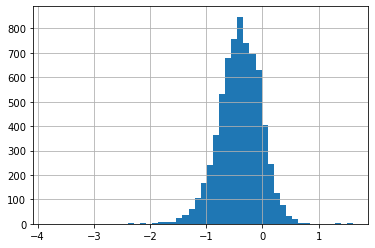

In [10]:
df_all['dmdtda'].hist(bins=50);

We load the preprocessed training DataFrame:

In [7]:
df_all.columns

Index(['rgi_id', 'hydro_year', 'PDD', 'RGI_ID', 'area', 'icecap', 'lat',
       'prcp_01', 'prcp_02', 'prcp_03', 'prcp_04', 'prcp_05', 'prcp_06',
       'prcp_07', 'prcp_08', 'prcp_09', 'prcp_10', 'prcp_11', 'prcp_12',
       'rain', 'slope', 'snow', 'temp_01', 'temp_02', 'temp_03', 'temp_04',
       'temp_05', 'temp_06', 'temp_07', 'temp_08', 'temp_09', 'temp_10',
       'temp_11', 'temp_12', 'zmax', 'zmed', 'zmin'],
      dtype='object')

## Informed feature selection

In this dataset we have already narrowed down a selection of training features for you. Nonetheless, in a research project, this step should not be taken for granted, since it can have a great impact on model design. 

The first question we should ask ouselves is: what variables affect the physical process we are trying to model here? In this case, we are talking about **glacier-wide mass balance**. Theory tells us that the integrated mass balance over the whole surface area of a glacier is impacted by both the climate and the topography of a glacier. 

Unlike point mass balance, the hypsometry of a glacier has a great impact on its glacier-wide mass balance. This is mainly manifested in two ways:
- The glacier surface slope affects ice flow dynamics, particularly the creep component. Generally, steeper glaciers have higher ice velocities, which imply a faster transfer of ice from the higher altitudes in the accumulation area to the lower altitudes in the ablation area. Therefore, a steep glacier will retreat faster (i.e. smaller surface area and higher mean altitude), but it will be able to move to higher altiudes with a colder climate. This helps the glacier find new colder climates in an effort to reach equilibrium. On the other hand, flatter glaciers and ice caps will not retreate as fast, since they react mostly through thinning (see Figure). This means that the glacier will move to lower altitudes with a warmer climate, further enhancing melt. This has an opposite effect to the one from steep mountain glaciers. 

- Steep mountain glaciers have a wider altitudinal range, meaning that they mass balance gradient will be higher and more complex. On the other hand, ice caps behave more similar to an ice cube: the reduced role of ice dynamics and their small altitudinal range imply a more homogenous mass balance gradient.

![Mountain glacier vs Ice cap retreat](Figures/Hock_Huss_glacier_icecap.png "Mountain glacier vs Ice cap retreat")
*Figure taken from Hock and Huss (2021).*

The next question at this point would be: what available data at the spatial and temporal scales that we are trying to model can I access? 